## 说明

输入：从声信号经提取出的三维特征矩阵，行(时序)列（特征种类）页（样本数量）

输出：训练曲线、精度与混淆热力图、二维特征空间

作者：许志翔（西安交通大学 车辆71）

联系方式：mr_xuzhixiang@qq.com

参考：孙玉林，余本国.PyTorch深度学习入门与实战.北京:水利水电出版社,2020.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns # 绘图
import torchvision.transforms as transforms
import torch.utils.data as Data
from scipy.io import loadmat # mat数据加载接口
from sklearn.model_selection import train_test_split # 用于数据集的切分
from sklearn.preprocessing import StandardScaler,MinMaxScaler # 数据标准化预处理
from sklearn.metrics import accuracy_score,confusion_matrix # 用于计算精度与混淆矩阵
from sklearn.manifold import TSNE # 降维
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 1. 加载数据集
file = 'D:\My files\diploma project\data\data_1.mat'

In [3]:
## mat_dtype=True，保证了导入后变量的数据类型与原类型一致。
data_1 = loadmat(file, mat_dtype=True)
print(type(data_1))

<class 'dict'>


In [4]:
## 导入后的data是一个字典，取出想要的变量字段即可。
X = data_1['Features_1']
Y = data_1['targets_1']

## matlab与python储存顺序不同，需要对三维矩阵进行旋转
X_p = np.transpose(X,(2,0,1))
X_p = X_p.reshape(700,1640)
## Y_p = Y.reshape(Y.shape[1])不知道为什么会报错
Y_p = Y.reshape(700)

## 将X,Y转为张量
x = torch.from_numpy(X_p.astype(np.float32))
y = torch.from_numpy(Y_p.astype(np.int64))

print('x.shape:',x.shape)
print('y.shape:',y.shape)

x.shape: torch.Size([700, 1640])
y.shape: torch.Size([700])


In [5]:
## 将数据随机切分为训练集75%和测试集25%
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=123)

## 数据归一化，特征值范围转化到0~1间
## 注意，只能对训练集使用fit
scales = MinMaxScaler(feature_range=(0,1))
x_train_s = scales.fit_transform(x_train)
x_test_s = scales.transform(x_test)

## 归一化后X又变成numpy了，再重新转成tensor
x_train_s = torch.from_numpy(x_train_s.astype(np.float32))
x_test_s = torch.from_numpy(x_test_s.astype(np.float32))

In [6]:
## 使用TensorDataset将x和y整理到一起
trainsets = Data.TensorDataset(x_train_s,y_train)

testsets = Data.TensorDataset(x_test_s,y_test)

In [7]:
# 2. 定义超参数
BATCH_SIZE = 16 # 每批读取的数据大小，我的电脑最多只能设16，写再高也是16
EPOCHS = 100 # 训练10轮

In [8]:
# 3. 创建数据集的可迭代对象，也就是说一个batch一个batch的读取数据
train_loader = Data.DataLoader(dataset=trainsets, batch_size=BATCH_SIZE, shuffle=True)

test_loader = Data.DataLoader(dataset=testsets, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
## 查看数据
images, labels = next(iter(test_loader))
print(images.shape)
print(labels.shape)

torch.Size([16, 1640])
torch.Size([16])


In [10]:
# 4. 搭建LSTM分类器
class LSTMimc(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMimc, self).__init__()
        self.hidden_dim = hidden_dim ## LSTM神经元个数
        self.layer_dim = layer_dim   ## LSTM的层数
        self.lstm = nn.LSTM(input_dim,hidden_dim,layer_dim,batch_first=True) ## nonlinearity='relu'
        ## 连接全连接层
        self.fc1 = nn.Linear(hidden_dim,output_dim) ## self.fc1 = nn.Linear(hidden_dim,output_dim)
        ## 添加dropout层
        ## self.dropout = nn.Dropout(p=0.5)  ## dropout训练
        
    def forward(self,x):
        ## x:[batch,time_step,input_dim]
        ## h_n:[layer_dim,batch,hidden_dim]
        h_0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c_0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (h_n, c_n) = self.lstm(x,(h_0.detach(),c_0.detach())) ## None表示h0会使用全0进行初始化
        ## 选取最后一个时间点的out输出
        ## out = self.dropout(out)
        out = self.fc1(out[:,-1,:])
        return out

In [11]:
# 5. 初始化模型
input_dim=40 ## 图片每行的像素数量
hidden_dim=64 ## RNN神经元个数
layer_dim=1 ## RNN的层数
output_dim=7 ## 隐藏层输出的维度（7类图像）
MyLSTMimc = LSTMimc(input_dim,hidden_dim,layer_dim,output_dim)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(MyLSTMimc)

LSTMimc(
  (lstm): LSTM(40, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=7, bias=True)
)


In [12]:
# 6. 对模型进行训练
sequence_dim = 41 ## 序列长度（矩阵有多少行）
optimizer = torch.optim.RMSprop(MyLSTMimc.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss() ## 损失函数
train_loss_all =[]
train_acc_all =[]
test_loss_all =[]
test_acc_all=[]
for epoch in range(EPOCHS):
    print('Epoch {}/{}'.format(epoch, EPOCHS-1))
    MyLSTMimc.train() ## 设置模型为训练模式
    corrects = 0
    train_num = 0
    for step,(b_x, b_y) in enumerate(train_loader):
        ## input [batch, time_step, input_dim]
        xdata =b_x.view(-1, sequence_dim, input_dim)
        output = MyLSTMimc(xdata)
        pre_lab = torch.argmax(output, 1)
        loss = criterion(output, b_y)
        optimizer.zero_grad ()
        loss.backward()
        optimizer.step()
        loss += loss.item() * b_x.size(0)
        corrects += torch.sum(pre_lab == b_y.data)
        train_num += b_x.size(0)
    ## 计算经过一个 epoch的训练后在训练集上的损失和精度
    train_loss_all.append (loss.data / train_num)
    train_acc_all.append(corrects.double().item()/train_num)
    print('{}Train Loss: {:.4f} Train Acc: {:.4f}'.format(
        epoch, train_loss_all[-1], train_acc_all[-1]))
    ## 设置模型为验证模式
    MyLSTMimc.eval()
    corrects = 0
    test_num = 0
    
    for step,(b_x, b_y) in enumerate (test_loader):
        ## input :[batch, time_step, input_dim]
        xdata = b_x.view(-1, sequence_dim, input_dim)
        output = MyLSTMimc(xdata)
        pre_lab= torch.argmax(output,1)
        loss = criterion(output,b_y)
        loss += loss.item()* b_x.size(0)
        corrects += torch.sum(pre_lab == b_y.data)
        test_num += b_x.size(0)
    ## 计算经过一个 epoch的训练后在测试集上的损失和精度
    test_loss_all.append(loss.data / test_num)
    test_acc_all.append(corrects.double().item()/test_num)
    print('{}Test Loss:{:.4f} Test Acc:{:.4f}'. format(
        epoch,test_loss_all[-1], test_acc_all[-1]))


Epoch 0/99
0Train Loss: 0.0498 Train Acc: 0.2171
0Test Loss:0.1715 Test Acc:0.2686
Epoch 1/99
1Train Loss: 0.0497 Train Acc: 0.2895
1Test Loss:0.1516 Test Acc:0.3771
Epoch 2/99
2Train Loss: 0.0444 Train Acc: 0.3790
2Test Loss:0.1585 Test Acc:0.3600
Epoch 3/99
3Train Loss: 0.0360 Train Acc: 0.4533
3Test Loss:0.1507 Test Acc:0.4057
Epoch 4/99
4Train Loss: 0.0349 Train Acc: 0.5333
4Test Loss:0.1199 Test Acc:0.5543
Epoch 5/99
5Train Loss: 0.0328 Train Acc: 0.5695
5Test Loss:0.1278 Test Acc:0.5486
Epoch 6/99
6Train Loss: 0.0354 Train Acc: 0.6152
6Test Loss:0.1135 Test Acc:0.5886
Epoch 7/99
7Train Loss: 0.0281 Train Acc: 0.6686
7Test Loss:0.1367 Test Acc:0.5086
Epoch 8/99
8Train Loss: 0.0302 Train Acc: 0.6514
8Test Loss:0.1223 Test Acc:0.6057
Epoch 9/99
9Train Loss: 0.0265 Train Acc: 0.6914
9Test Loss:0.1135 Test Acc:0.6286
Epoch 10/99
10Train Loss: 0.0233 Train Acc: 0.6857
10Test Loss:0.0970 Test Acc:0.7029
Epoch 11/99
11Train Loss: 0.0309 Train Acc: 0.7371
11Test Loss:0.0963 Test Acc:0.680

96Train Loss: 0.0014 Train Acc: 0.9943
96Test Loss:0.0184 Test Acc:0.9429
Epoch 97/99
97Train Loss: 0.0002 Train Acc: 1.0000
97Test Loss:0.0015 Test Acc:0.9771
Epoch 98/99
98Train Loss: 0.0003 Train Acc: 1.0000
98Test Loss:0.0021 Test Acc:0.9771
Epoch 99/99
99Train Loss: 0.0003 Train Acc: 1.0000
99Test Loss:0.0290 Test Acc:0.9714


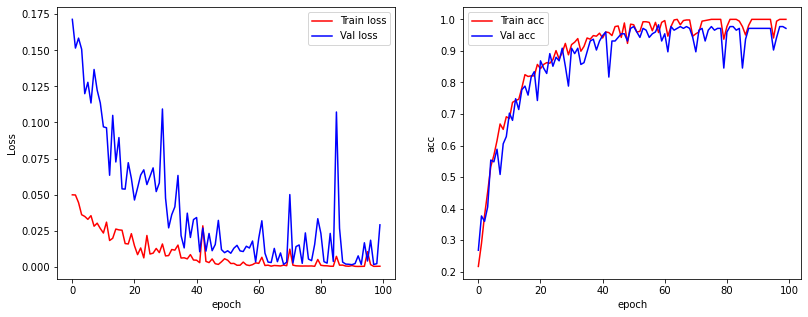

In [13]:
# 7. 可视化模型训练过程
plt.figure(figsize=(6.67*2, 5.0))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, "r", label ="Train loss")
plt.plot(test_loss_all,"b", label ="Val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(train_acc_all, "r", label ="Train acc")
plt.plot(test_acc_all,"b", label ="Val acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.savefig('all.png')
plt.show()

In [14]:
print(output.data[1])
pre_lab = torch.argmax(output,1)[1]
print(pre_lab)

tensor([ 6.9658,  1.4250, -3.6616, -6.7012, -1.5701,  0.8450, -1.1091])
tensor(0)


In [15]:
print(output.data)
pre_lab = torch.argmax(output,1)
print(pre_lab)

tensor([[-1.5758, -1.6791,  0.9534, -0.1277, -2.8732, -3.1259,  6.0115],
        [ 6.9658,  1.4250, -3.6616, -6.7012, -1.5701,  0.8450, -1.1091],
        [-1.7809,  1.0561, -3.1819, -0.6788, -3.8852,  1.4078,  4.8958],
        [-1.1748,  0.8059, -2.5304, -0.8749,  6.4652, -0.6241, -2.5572],
        [-1.7099,  6.2711, -3.0843, -0.2073, -3.2106,  0.7890,  0.0422],
        [-1.2325,  6.4745, -5.5827,  0.7339, -0.4380, -0.4899, -0.0137],
        [-2.7951,  0.2736,  0.0081,  0.8210, -4.3271, -0.8813,  5.7768],
        [ 0.9480, -5.3146,  6.2034, -1.6153, -1.3572,  0.4149, -2.0403],
        [-1.7352,  3.6663, -2.9630,  3.2309, -2.2034, -0.7499, -1.4118],
        [ 7.2943, -0.1187,  0.1107, -5.9164, -2.9796, -2.5173,  0.3407],
        [-2.4048,  2.0187, -3.2429,  0.8707,  4.3480,  0.4229, -2.2644],
        [ 1.4600,  5.2251, -3.5360, -1.0406,  0.9331, -2.8718, -1.6885],
        [-1.5497, -4.3927,  6.1034,  0.4347, -1.2103,  0.5779, -1.3785],
        [-2.9216,  1.4462, -1.6377, -0.0648, -4.093

在测试集上的预测精度为： 0.9714285714285714


<function matplotlib.pyplot.show(*args, **kw)>

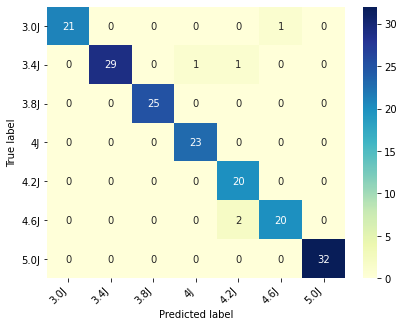

In [16]:
# 8. 精度与混淆矩阵热力图 
MyLSTMimc.eval()
test_y_all = torch.LongTensor()
pre_lab_all = torch.LongTensor()
for step,(b_x, b_y) in enumerate (test_loader):
    ## input :[batch, time_step, input_dim]
    xdata = b_x.view(-1, sequence_dim, input_dim)
    output = MyLSTMimc(xdata)
    pre_lab= torch.argmax(output,1)
    test_y_all = torch.cat((test_y_all,b_y)) ## 测试集的标签
    pre_lab_all = torch.cat((pre_lab_all,pre_lab)) ## 测试集的预测标签
acc = accuracy_score(test_y_all,pre_lab_all)
print("在测试集上的预测精度为：",acc)

## 计算混淆矩阵并可视化
plt.figure(figsize=(6.67, 5.0))
class_label = ['3.0J','3.4J','3.8J','4J','4.2J','4.6J','5.0J']
conf_mat = confusion_matrix(test_y_all,pre_lab_all) ## 输出是判断对的个数而不是准确率
df_cm = pd.DataFrame(conf_mat, index=class_label, columns=class_label)
heatmap = sns.heatmap(df_cm, annot=True, fmt='d',cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                             rotation=0,
                             ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                             rotation=45,
                             ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show

In [17]:
# 9. 特征空间可视化 
## 定义一个辅助函数，来获取指定层名称的特征
activation = {} ## 保存不同层的输出
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook    

In [18]:
## 设置向fc1层注册一个hook获取输出
MyLSTMimc.fc1.register_forward_hook(get_activation('fc1'))
test_data = x_train_s.view(-1, sequence_dim, input_dim)
_ = MyLSTMimc(test_data)
fc1 = activation['fc1'].data.numpy()
print('fc1.shape:',fc1.shape)

fc1.shape: (525, 7)


In [19]:
## 对输出进行降维
tsne = TSNE(n_components=2, random_state=0)
fc1_2d = tsne.fit_transform(fc1.data) 
target_ids = range(output_dim)
print('fc1_2d.shape:',fc1_2d.shape)

fc1_2d.shape: (525, 2)


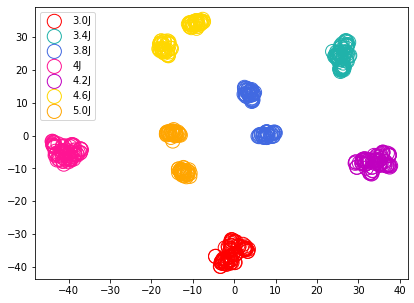

In [20]:
## 绘制特征空间
plt.figure(figsize=(6.67, 5.0))
colors = 'r', 'lightseagreen', 'royalblue', 'deeppink', 'm', 'gold', 'orange'

for i, edgecolors, label in zip(target_ids, colors, class_label):
    plt.scatter(fc1_2d[y_train == i, 0], fc1_2d[y_train == i, 1], edgecolors=edgecolors,c='none',s=200,label=label)

plt.legend()
plt.show()